In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import vpi
import time

In [43]:
def get_calibration() -> tuple:
    fs = cv2.FileStorage(
        "rectify_map_imx219_160deg_1080p.yaml", cv2.FILE_STORAGE_READ
    )

    map_l = (fs.getNode("map_l_x").mat(), fs.getNode("map_l_y").mat())

    map_r = (fs.getNode("map_r_x").mat(), fs.getNode("map_r_y").mat())

    fs.release()

    return map_l, map_r

def make_vpi_warpmap(cv_maps) -> vpi.WarpMap:
    
    src_map = cv_maps[0]
    idk_what_that_is = cv_maps[1]
    map_y, map_x = src_map[:,:,0], src_map[:,:,1]
    
    warp = vpi.WarpMap(vpi.WarpGrid((1920,1080)))
    # (H, W, C) -> (C,H,W)
    arr_warp = np.asarray(warp)
    wx = arr_warp[:,:,0]
    wy = arr_warp[:,:,1]

    wy[:1080,:] = map_x
    wx[:1080,:] = map_y
    
    return warp

In [44]:
map_l, map_r = get_calibration()

In [45]:
warp_l = make_vpi_warpmap(map_l)
warp_r = make_vpi_warpmap(map_r)

## VPI remap

In [46]:
!ls 1080p_stereo_calib/left/001.png

1080p_stereo_calib/left/001.png


In [47]:
arr_in = np.asarray(Image.open('1080p_stereo_calib/left/001.png'))
vpi_img = vpi.asimage(arr_in)

In [50]:
t1 = time.perf_counter()

with vpi.Backend.CUDA:
    for _ in range(200):
        vpi_img_out = vpi_img.remap(warp_l)
        arr_out = vpi_img_out.cpu()
        
t2 = time.perf_counter()

print(f"{200/(t2 - t1)} FPS")

251.97716782120418 FPS


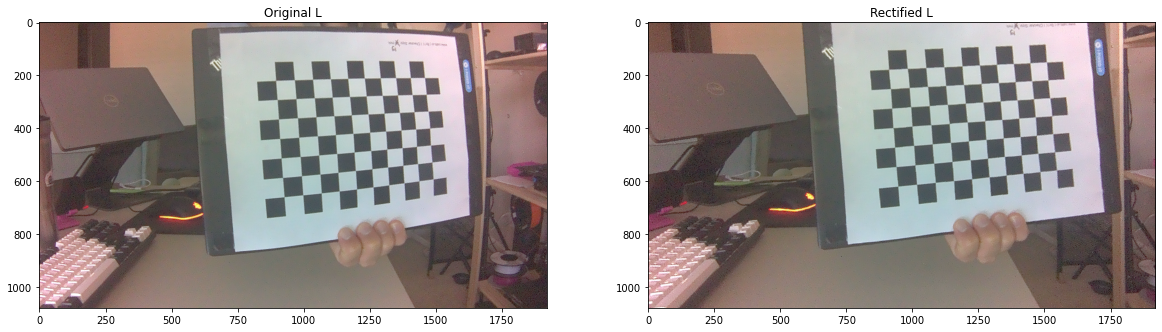

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

# before
axs[0].title.set_text('Original L')
axs[0].imshow(arr_in)

axs[1].title.set_text('Rectified L')
axs[1].imshow(arr_out)